# Visibility Simulator Examples

Although ``hera_sim`` is primarily aimed at simulating instrumental effects _on top_ of existing visibility simulations, it also provides a neat interface to several visibility simulators.

It does so through the base class ``VisibilitySimulator``, which sets a standard API from which all simulators must derive.

## VisCPU

In [1]:
from hera_sim.visibilities import VisCPU, HealVis
from hera_sim import io
import numpy as np
import healpy
import matplotlib.pyplot as plt
import itertools
from pyuvsim.analyticbeam import AnalyticBeam

%matplotlib inline

%load_ext autoreload
%autoreload 2

In [3]:
def plot_blts(simulator):
    fig, ax = plt.subplots(2, 1, sharex=True, 
                           subplot_kw={"ylabel":"|Visibility| [Jy]"})

    for i in simulator.uvdata.antenna_numbers:
        auto_ind = simulator.uvdata.antpair2ind((i,i))

        ax[0].plot(np.unique(simulator.uvdata.lst_array)*12/np.pi, 
                   np.abs(simulator.uvdata.data_array[auto_ind, 0, 0, 0]), label="ant_{}".format(i))

        for j in simulator.uvdata.antenna_numbers[(i+1):]:
            cross_ind = simulator.uvdata.antpair2ind((i,j))
            ax[1].plot(np.unique(simulator.uvdata.lst_array)*12/np.pi, np.abs(simulator.uvdata.data_array[cross_ind, 0, 0, 0]), label="bl({},{})".format(i,j))

    ax[0].legend()
    ax[1].legend()
    ax[0].set_title("Autocorrelations")
    ax[1].set_title("Cross-Correlations")
    ax[1].set_xlabel("LST (hours)");

``VisCPU`` natively deals with diffuse emission, and the ``VisibilitySimulator`` uses ``healpix`` maps to represent such emission:

In [4]:
def uniform_sky(nside_base=5, scale=1, nfreqs=5):
    NSIDE = 2**nside_base
    NPIX = 12 * NSIDE**2 # this is the number of pixels a healpix map has for  given NSIDE

    # Create a sky of purely ones, multiply by "scale"
    return scale* np.ones((nfreqs, NPIX))/NPIX

Other than the sky model (we'll revisit this soon), the ``VisibilitySimulator`` requires a ``UVData`` object to specify the observation parameters, as well as a list of ``UVBeam``s to specify the beams for each antenna. This makes it fully consistent with the interface provided by ``pyuvsim``, and many of the methods found in ``pyuvsim`` for creating ``UVData`` objects and ``UVBeam`` objects from YAML specifications can be used here. Indeed, a dictionary of so-called ``obsparams``, or a file-name for an appropriate YAML file, can be passed in lieu of the ``UVData`` and ``UVBeam``. 

For simplicity, let us simply use the native ``empty_uvdata`` function instead:

In [41]:
def myuvdata():
    return io.empty_uvdata(
        nfreq = 5,
        time_per_integ = 1800.0,
        ntimes= 48,
        ants = {
            0: (0,0,0),
            1: (20,20,0),
            2: (-20,20,0),
        },
        antpairs = sum([[(a,b) for a in range(3)] for b in range(3)], [])
    )

freqs = np.unique(myuvdata().freq_array)

In [42]:
simulator = VisCPU(
    uvdata = myuvdata(),
    sky_intensity = uniform_sky(5),
    sky_freqs = freqs,
)

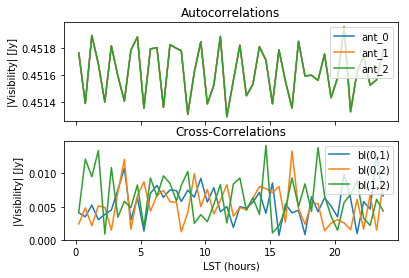

In [43]:
vis = simulator.simulate()
plot_blts(simulator)

Test whether increasing the number of pixels changes much

In [44]:
simulator = VisCPU(
    uvdata = myuvdata(),
    sky_intensity = uniform_sky(6),
    sky_freqs = freqs,
)

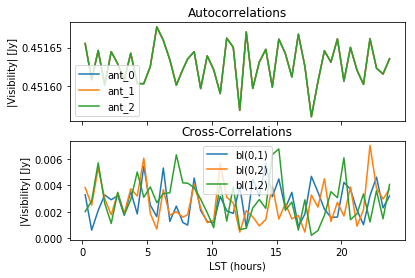

In [45]:
vis = simulator.simulate()
plot_blts(simulator)

### Point Sources

In [46]:
point_source_pos = np.array([(0, myuvdata().telescope_lat_lon_alt[0].value)]) # ra, dec)
point_source_flx = np.array([[1.0]*len(freqs)]).T

In [47]:
simulator = VisCPU(
    uvdata = myuvdata(),
    point_source_pos=point_source_pos,
    point_source_flux = point_source_flx,
    sky_freqs = freqs,
)

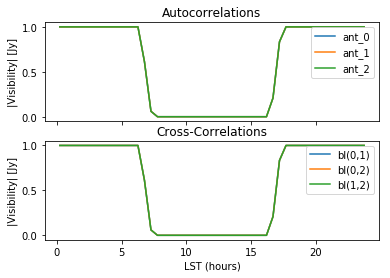

In [48]:
vis = simulator.simulate()
plot_blts(simulator)

In [14]:
point_source_pos = np.array([ # ra, dec
    (0, myuvdata().telescope_lat_lon_alt[0].value),
    (0.1, myuvdata().telescope_lat_lon_alt[0].value)
]) 
point_source_flx = np.array([[1.0, 1.0]]*len(freqs))

In [15]:
simulator = VisCPU(
    uvdata = myuvdata(),
    point_source_pos=point_source_pos,
    point_source_flux = point_source_flx,
    sky_freqs = freqs,
)

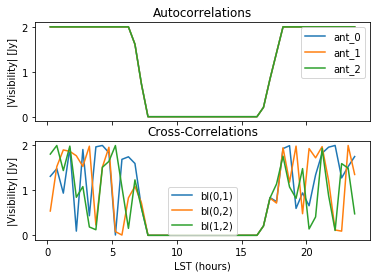

In [16]:
vis = simulator.simulate()
plot_blts(simulator)

In this, the beam was not set, and therefore the beam was assumed to be unity everywhere above the horizon. The beam can be set as a series of healpix maps, one for each antenna. 
An extra list of ``beam_ids`` specifies which of the beams each antenna uses. So, we can create something like a Gaussian beam:

In [17]:
simulator = VisCPU(
    uvdata = myuvdata(),
    sky_intensity = uniform_sky(6),
    sky_freqs = freqs,
    beams = [AnalyticBeam("gaussian", diameter=14)]
)

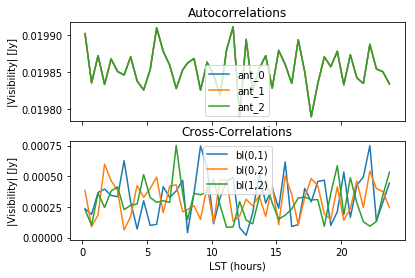

In [18]:
vis = simulator.simulate()
plot_blts(simulator)

## HealVis

We could also have used healvis for this:

In [34]:
simulator = HealVis(
    uvdata = myuvdata(),
    sky_freqs = freqs,
    sky_intensity = 100*uniform_sky(6),
)

In [35]:
vis = simulator.simulate()

(3.92, 3.98)

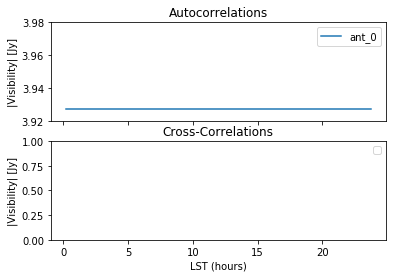

In [36]:
plot_blts(simulator)
fig = plt.gcf()
ax = fig.axes[0]
ax.set_ylim(3.92, 3.98)

In [37]:
auto_ind = simulator.uvdata.antpair2ind((0,0))


np.abs(simulator.uvdata.data_array[auto_ind, 0, 0, 0])

array([3.9274745, 3.9274745, 3.9274745, 3.9274745, 3.9274745, 3.9274745,
       3.9274745, 3.9274745, 3.9274745, 3.9274745, 3.9274745, 3.9274745,
       3.9274745, 3.9274745, 3.9274745, 3.9274745, 3.9274745, 3.9274745,
       3.9274745, 3.9274745, 3.9274745, 3.9274745, 3.9274745, 3.9274745,
       3.9274745, 3.9274745, 3.9274745, 3.9274745, 3.9274745, 3.9274745,
       3.9274745, 3.9274745, 3.9274745, 3.9274745, 3.9274745, 3.9274745,
       3.9274745, 3.9274745, 3.9274745, 3.9274745, 3.9274745, 3.9274745,
       3.9274745, 3.9274745, 3.9274745, 3.9274745, 3.9274745, 3.9274745],
      dtype=float32)

In [40]:
simulator.uvdata.data_array.shape

(48, 1, 5, 1)

In [39]:
simulator.uvdata.data_array

array([[[[3.9274745+0.j],
         [3.9351492+0.j],
         [3.9428313+0.j],
         [3.9505208+0.j],
         [3.9582179+0.j]]],


       [[[3.9274745+0.j],
         [3.9351492+0.j],
         [3.9428313+0.j],
         [3.9505208+0.j],
         [3.9582179+0.j]]],


       [[[3.9274745+0.j],
         [3.9351492+0.j],
         [3.9428313+0.j],
         [3.9505208+0.j],
         [3.9582179+0.j]]],


       [[[3.9274745+0.j],
         [3.9351492+0.j],
         [3.9428313+0.j],
         [3.9505208+0.j],
         [3.9582179+0.j]]],


       [[[3.9274745+0.j],
         [3.9351492+0.j],
         [3.9428313+0.j],
         [3.9505208+0.j],
         [3.9582179+0.j]]],


       [[[3.9274745+0.j],
         [3.9351492+0.j],
         [3.9428313+0.j],
         [3.9505208+0.j],
         [3.9582179+0.j]]],


       [[[3.9274745+0.j],
         [3.9351492+0.j],
         [3.9428313+0.j],
         [3.9505208+0.j],
         [3.9582179+0.j]]],


       [[[3.9274745+0.j],
         [3.9351492+0.j],
         [